In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [51]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [52]:
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [53]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [54]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
   param.requires_grad = False

In [55]:
class FCN32(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN32, self).__init__()
        self.vgg16 = vgg16.features
        self.conv1 = self.make_block(in_channel=3, out_channel=64,repeat=2)
        self.conv2 = self.make_block(in_channel=64,out_channel=128,repeat=2)
        self.conv3 = self.make_block(128,256,3)
        self.conv4 = self.make_block(256,512,3)
        self.conv5 = self.make_block(512,512,3)

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=7)
        self.fc2 = nn.Conv2d(4096,4096,1)
        self.fc3 = nn.Conv2d(4096,num_class,1)

        self.upsample32 = nn.ConvTranspose2d(in_channels=num_class,out_channels=num_class,
        kernel_size=224,stride=32)
    
    def forward(self, x):
        # x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.conv5(x)
        x = self.vgg16(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc3(x)
        x = self.upsample32(x)
        return x

    def make_block(self, in_channel, out_channel, repeat):
        layers = []
        for i in range(repeat):
            if (i==0):
                layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
            else:
                layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        block = nn.Sequential(*layers)

        return block

In [56]:
FCN =FCN32(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792               0
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928               0
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856               0
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584               0
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.0001)

In [58]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)
            

In [59]:
# 학습
FCN.to(device)
epochs= 100
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_loss = np.inf
stop_count = 0
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)

        if min_loss < val_running_loss:
            min_loss = val_running_loss
            stop_count +=1
            if stop_count == 5:
                print('Stop loss not decrease')

                break
        else:
            min_loss = val_running_loss
            #print('save model')
            torch.save(FCN, './models/FCN-Vgg16.pt')


        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list}
print('Finish Training')

366it [00:49,  7.39it/s]
363it [00:20, 17.53it/s]


1 epcoh , time = 71.77
train loss : 1.32150, val_loss : 1.16487
train IoU : 0.12842, val IoU : 0.13051


366it [00:49,  7.33it/s]
363it [00:19, 18.17it/s]


2 epcoh , time = 71.42
train loss : 1.03928, val_loss : 0.95607
train IoU : 0.14545, val IoU : 0.16082


366it [00:49,  7.33it/s]
363it [00:20, 17.81it/s]


3 epcoh , time = 71.81
train loss : 0.86442, val_loss : 0.88749
train IoU : 0.18515, val IoU : 0.20407


366it [00:50,  7.22it/s]
363it [00:20, 17.84it/s]


4 epcoh , time = 72.58
train loss : 0.74756, val_loss : 0.79294
train IoU : 0.22653, val IoU : 0.22209


366it [00:50,  7.28it/s]
363it [00:20, 18.04it/s]


5 epcoh , time = 71.89
train loss : 0.65300, val_loss : 0.77669
train IoU : 0.26249, val IoU : 0.25343


366it [00:49,  7.35it/s]
363it [00:20, 17.77it/s]


6 epcoh , time = 71.76
train loss : 0.59390, val_loss : 0.72830
train IoU : 0.27656, val IoU : 0.24931


366it [00:49,  7.33it/s]
363it [00:20, 17.72it/s]


7 epcoh , time = 71.89
train loss : 0.55024, val_loss : 0.71831
train IoU : 0.29855, val IoU : 0.26278


366it [00:50,  7.24it/s]
363it [00:19, 18.16it/s]


8 epcoh , time = 72.03
train loss : 0.51299, val_loss : 0.71615
train IoU : 0.31979, val IoU : 0.26874


366it [00:50,  7.25it/s]
363it [00:20, 18.15it/s]


9 epcoh , time = 72.04
train loss : 0.48479, val_loss : 0.69015
train IoU : 0.33475, val IoU : 0.27287


366it [00:50,  7.29it/s]
363it [00:20, 18.11it/s]


10 epcoh , time = 70.25
train loss : 0.45752, val_loss : 0.69303
train IoU : 0.34780, val IoU : 0.26933


366it [00:49,  7.37it/s]
363it [00:20, 18.15it/s]


11 epcoh , time = 71.15
train loss : 0.43654, val_loss : 0.68792
train IoU : 0.36048, val IoU : 0.29416


366it [00:49,  7.34it/s]
363it [00:20, 17.71it/s]


12 epcoh , time = 70.39
train loss : 0.41527, val_loss : 0.70428
train IoU : 0.37623, val IoU : 0.26475


366it [00:49,  7.33it/s]
363it [00:20, 17.98it/s]


13 epcoh , time = 71.60
train loss : 0.40448, val_loss : 0.67755
train IoU : 0.38429, val IoU : 0.27763


366it [00:49,  7.34it/s]
363it [00:20, 17.45it/s]


14 epcoh , time = 72.16
train loss : 0.39078, val_loss : 0.67664
train IoU : 0.40076, val IoU : 0.30280


366it [00:50,  7.30it/s]
363it [00:20, 17.93it/s]


15 epcoh , time = 71.86
train loss : 0.38038, val_loss : 0.67383
train IoU : 0.40512, val IoU : 0.29692


366it [00:49,  7.36it/s]
363it [00:19, 18.18it/s]


16 epcoh , time = 71.17
train loss : 0.36741, val_loss : 0.66918
train IoU : 0.41922, val IoU : 0.31203


366it [00:50,  7.30it/s]
363it [00:20, 17.48it/s]


17 epcoh , time = 70.88
train loss : 0.35810, val_loss : 0.67925
train IoU : 0.42653, val IoU : 0.29840


366it [00:49,  7.34it/s]
363it [00:20, 17.67it/s]


18 epcoh , time = 71.92
train loss : 0.35034, val_loss : 0.67918
train IoU : 0.43279, val IoU : 0.31145


366it [00:50,  7.24it/s]
363it [00:20, 17.63it/s]


19 epcoh , time = 72.68
train loss : 0.34187, val_loss : 0.67485
train IoU : 0.44431, val IoU : 0.32149


366it [00:49,  7.32it/s]
363it [00:20, 17.57it/s]


20 epcoh , time = 72.27
train loss : 0.33013, val_loss : 0.67059
train IoU : 0.45448, val IoU : 0.32393


366it [00:50,  7.30it/s]
363it [00:20, 17.90it/s]


21 epcoh , time = 71.88
train loss : 0.32294, val_loss : 0.66927
train IoU : 0.45804, val IoU : 0.32657


366it [00:50,  7.22it/s]
363it [00:21, 16.89it/s]


22 epcoh , time = 73.66
train loss : 0.31390, val_loss : 0.66924
train IoU : 0.46606, val IoU : 0.31325


366it [00:51,  7.13it/s]
363it [00:20, 17.81it/s]


23 epcoh , time = 73.21
train loss : 0.30672, val_loss : 0.66479
train IoU : 0.47436, val IoU : 0.32347


366it [00:50,  7.23it/s]
363it [00:20, 17.87it/s]


24 epcoh , time = 72.40
train loss : 0.30140, val_loss : 0.66422
train IoU : 0.48222, val IoU : 0.32569


366it [00:50,  7.29it/s]
363it [00:20, 17.87it/s]


25 epcoh , time = 70.53
train loss : 0.29466, val_loss : 0.66980
train IoU : 0.48722, val IoU : 0.32367


366it [00:50,  7.25it/s]
363it [00:20, 17.35it/s]


26 epcoh , time = 72.93
train loss : 0.28546, val_loss : 0.66687
train IoU : 0.49591, val IoU : 0.32654


366it [00:50,  7.29it/s]
363it [00:19, 18.16it/s]


27 epcoh , time = 70.21
train loss : 0.28364, val_loss : 0.67533
train IoU : 0.50700, val IoU : 0.32539


366it [00:49,  7.34it/s]
363it [00:20, 17.82it/s]


28 epcoh , time = 71.71
train loss : 0.28020, val_loss : 0.67356
train IoU : 0.50616, val IoU : 0.32102


366it [00:49,  7.35it/s]
363it [00:20, 17.88it/s]


29 epcoh , time = 71.64
train loss : 0.27400, val_loss : 0.66140
train IoU : 0.51433, val IoU : 0.32141


366it [00:50,  7.30it/s]
363it [00:20, 17.75it/s]


30 epcoh , time = 70.59
train loss : 0.27125, val_loss : 0.67064
train IoU : 0.51984, val IoU : 0.31843


366it [00:50,  7.29it/s]
363it [00:20, 17.54it/s]


31 epcoh , time = 70.91
train loss : 0.25933, val_loss : 0.67334
train IoU : 0.52667, val IoU : 0.31636


366it [00:50,  7.32it/s]
363it [00:20, 17.76it/s]


32 epcoh , time = 71.99
train loss : 0.25396, val_loss : 0.66161
train IoU : 0.53531, val IoU : 0.32733


366it [00:49,  7.34it/s]
363it [00:20, 17.82it/s]


33 epcoh , time = 70.25
train loss : 0.25212, val_loss : 0.68158
train IoU : 0.53653, val IoU : 0.33545


366it [00:50,  7.21it/s]
363it [00:20, 17.43it/s]


34 epcoh , time = 73.13
train loss : 0.24875, val_loss : 0.67308
train IoU : 0.54314, val IoU : 0.33351


366it [00:50,  7.19it/s]
363it [00:20, 17.76it/s]


35 epcoh , time = 72.83
train loss : 0.24441, val_loss : 0.67153
train IoU : 0.54859, val IoU : 0.34083


366it [00:50,  7.22it/s]
363it [00:21, 16.79it/s]


36 epcoh , time = 72.32
train loss : 0.23933, val_loss : 0.68163
train IoU : 0.55419, val IoU : 0.32796


366it [00:50,  7.18it/s]
363it [00:21, 17.16it/s]


37 epcoh , time = 73.65
train loss : 0.23280, val_loss : 0.67607
train IoU : 0.56521, val IoU : 0.33568


366it [00:50,  7.21it/s]
363it [00:20, 17.79it/s]


38 epcoh , time = 72.66
train loss : 0.22960, val_loss : 0.66921
train IoU : 0.56673, val IoU : 0.33856


366it [00:49,  7.33it/s]
363it [00:20, 17.80it/s]


39 epcoh , time = 70.34
train loss : 0.22773, val_loss : 0.67482
train IoU : 0.56945, val IoU : 0.34216


366it [00:50,  7.26it/s]
363it [00:20, 17.89it/s]


40 epcoh , time = 70.69
train loss : 0.22762, val_loss : 0.69241
train IoU : 0.56884, val IoU : 0.31306


366it [00:49,  7.35it/s]
363it [00:20, 17.76it/s]


41 epcoh , time = 71.76
train loss : 0.22164, val_loss : 0.67560
train IoU : 0.58012, val IoU : 0.34096


366it [00:50,  7.26it/s]
363it [00:20, 17.91it/s]


42 epcoh , time = 70.66
train loss : 0.21376, val_loss : 0.68054
train IoU : 0.58667, val IoU : 0.33270


366it [00:50,  7.19it/s]
363it [00:20, 17.97it/s]


43 epcoh , time = 71.13
train loss : 0.21333, val_loss : 0.68104
train IoU : 0.58790, val IoU : 0.34320


366it [00:50,  7.31it/s]
363it [00:20, 17.64it/s]


44 epcoh , time = 70.68
train loss : 0.20940, val_loss : 0.68202
train IoU : 0.59075, val IoU : 0.33746


366it [00:50,  7.24it/s]
363it [00:20, 17.94it/s]


45 epcoh , time = 72.31
train loss : 0.20835, val_loss : 0.67305
train IoU : 0.59881, val IoU : 0.34312


366it [00:50,  7.32it/s]
363it [00:20, 17.93it/s]


46 epcoh , time = 70.28
train loss : 0.20495, val_loss : 0.68268
train IoU : 0.60088, val IoU : 0.34016


366it [00:49,  7.35it/s]
363it [00:20, 18.05it/s]


47 epcoh , time = 71.47
train loss : 0.20234, val_loss : 0.68263
train IoU : 0.60516, val IoU : 0.34337


366it [00:49,  7.39it/s]
363it [00:20, 18.06it/s]


48 epcoh , time = 69.66
train loss : 0.19763, val_loss : 0.68322
train IoU : 0.61108, val IoU : 0.32989


366it [00:49,  7.38it/s]
363it [00:20, 17.90it/s]


49 epcoh , time = 69.91
train loss : 0.20106, val_loss : 0.68952
train IoU : 0.61137, val IoU : 0.33124


366it [00:50,  7.28it/s]
363it [00:20, 17.76it/s]


50 epcoh , time = 72.19
train loss : 0.19536, val_loss : 0.67936
train IoU : 0.61489, val IoU : 0.34650


366it [00:49,  7.38it/s]
363it [00:20, 18.13it/s]


51 epcoh , time = 69.62
train loss : 0.19257, val_loss : 0.69625
train IoU : 0.62266, val IoU : 0.33083


366it [00:49,  7.33it/s]
363it [00:20, 18.05it/s]


52 epcoh , time = 71.57
train loss : 0.18891, val_loss : 0.68320
train IoU : 0.61905, val IoU : 0.33280


366it [00:49,  7.35it/s]
363it [00:20, 18.02it/s]


53 epcoh , time = 69.94
train loss : 0.18741, val_loss : 0.69949
train IoU : 0.62304, val IoU : 0.33579


366it [00:50,  7.29it/s]
363it [00:20, 17.63it/s]


54 epcoh , time = 72.28
train loss : 0.18580, val_loss : 0.68547
train IoU : 0.63109, val IoU : 0.34460


366it [00:49,  7.33it/s]
363it [00:20, 17.31it/s]


55 epcoh , time = 70.90
train loss : 0.18210, val_loss : 0.68921
train IoU : 0.63325, val IoU : 0.33259


366it [00:50,  7.30it/s]
363it [00:20, 17.88it/s]


56 epcoh , time = 70.44
train loss : 0.18197, val_loss : 0.69123
train IoU : 0.64069, val IoU : 0.34094


366it [00:50,  7.31it/s]
363it [00:20, 17.71it/s]


57 epcoh , time = 70.57
train loss : 0.17865, val_loss : 0.70535
train IoU : 0.63328, val IoU : 0.33554


366it [00:49,  7.36it/s]
363it [00:20, 17.72it/s]


58 epcoh , time = 71.69
train loss : 0.17669, val_loss : 0.69918
train IoU : 0.63967, val IoU : 0.33262


366it [00:50,  7.21it/s]
363it [00:21, 17.07it/s]


59 epcoh , time = 72.00
train loss : 0.17306, val_loss : 0.70425
train IoU : 0.64626, val IoU : 0.33244


366it [00:50,  7.28it/s]
363it [00:21, 17.26it/s]


60 epcoh , time = 72.81
train loss : 0.17380, val_loss : 0.69591
train IoU : 0.65172, val IoU : 0.34141


214it [00:30,  7.13it/s]


KeyboardInterrupt: 

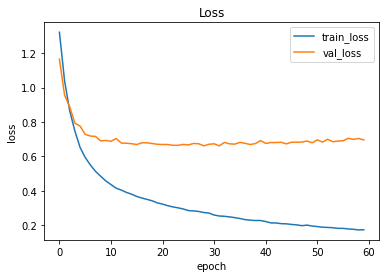

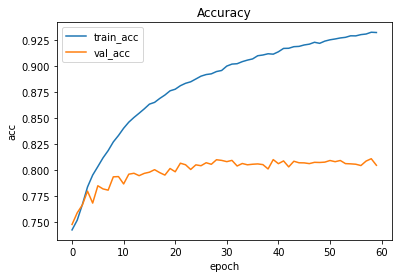

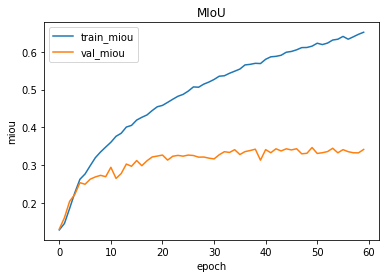

In [61]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

torch.Size([4, 3, 224, 224])
torch.Size([4, 21, 224, 224])
torch.Size([4, 224, 224])


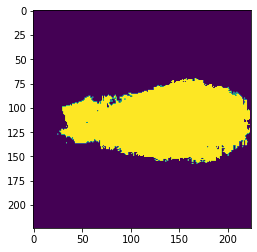

In [ ]:
a, b= train_set[0]
FCN.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        a, b = data
        FCN.to(device)
        print(a.shape)
        a = a.to(device)
        c = FCN(a)
        break

print(c.shape)
mask = torch.argmax(c, dim=1)
print(mask.shape)
#print(c[0])
plt.imshow(mask[0].cpu())
# t = a.view(8,224,224,3)
# # t = t.view(224,224,3)
# plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
# plt.imshow(mask[0].cpu())
# plt.subplot(1,3,2)
# plt.imshow(b[0].cpu())
# plt.subplot(1,3,3)
# plt.imshow(t[0].cpu())
